# QC Summary

In [1]:
import json
import os
import numpy as np
import pandas as pd
from collections import Counter
from nipype.interfaces.fsl.model import MELODIC

In [4]:
func_path = '/pool/home/AD_Multimodal/Estudio_A4/fmri_slicetiming_outputderivatives/rs_preproc'

qc_file_name = 'qc_decisions.json'
qc_decision_file = os.path.join(func_path, qc_file_name)

with open(qc_decision_file, 'r') as f:
    qc_decisions = json.load(f)

rejected_subjects_file = 'automatic_rejections.csv'
rejected_subjects_df = pd.read_csv(os.path.join(func_path, rejected_subjects_file))

rejected_subjects = rejected_subjects_df['subject_id'].to_list()

print(f'Number of subjects rejected by the automatic pipeline: {len(rejected_subjects)}')


Number of subjects rejected by the automatic pipeline: 51


In [5]:
# Find all subjects that have to be reviewed

subjects_to_review = {}
count = 0

# In the func path find all folders that start with sub-
for subject in os.listdir(func_path):
    if subject.startswith('sub-'):
        count += 1
        report_path = os.path.join(func_path, subject, 'ses-01', 'report', f'report_{subject}.html')
        if os.path.exists(report_path):
            if subject not in rejected_subjects:
                subjects_to_review[subject] = 0
        else:
            print(f'Report not found for {subject}')

print('-'*50)
print(f'Found {len(subjects_to_review)} subjects to review')
print('-'*50)
print('Total number of subjects: ', count)

Report not found for sub-B59357538
Report not found for sub-B11343379
Report not found for sub-B18059441
Report not found for sub-B96720897
Report not found for sub-B76963674
Report not found for sub-B39629855
Report not found for sub-B89319327
Report not found for sub-B89285582
Report not found for sub-B41205825
Report not found for sub-B86838929
Report not found for sub-B78077581
Report not found for sub-B16177117
Report not found for sub-B95701328
Report not found for sub-B32186247
--------------------------------------------------
Found 1113 subjects to review
--------------------------------------------------
Total number of subjects:  1178


In [6]:
# qc_decisions = {'marc': {'sub-001': 1, 'sub-002': 0}, 'roser': {'sub-003': 1, 'sub-004': 0}}

for reviewer, decisions in qc_decisions.items():
    for subject, decision in decisions.items():
        if subject in subjects_to_review:
            subjects_to_review[subject] += 1

review_counts = Counter(subjects_to_review.values())

print('Total subjects:', len(subjects_to_review))

print('Subjects reviewed by 0 reviewers:', review_counts[0])
print('Subjects reviewed by 1 reviewer:', review_counts[1])
print('Subjects reviewed by 2 reviewers:', review_counts[2])
print('Subjects reviewed by 3 reviewers:', review_counts[3])


Total subjects: 1113
Subjects reviewed by 0 reviewers: 0
Subjects reviewed by 1 reviewer: 202
Subjects reviewed by 2 reviewers: 269
Subjects reviewed by 3 reviewers: 642


In [7]:
import os
import json
from collections import defaultdict

# Define the path to the QC decisions file
func_path = '/pool/home/AD_Multimodal/Estudio_A4/fmri_slicetiming_outputderivatives/rs_preproc'
qc_file_name = 'qc_decisions.json'
qc_decision_file = os.path.join(func_path, qc_file_name)

# Load the QC decisions from the JSON file
with open(qc_decision_file, 'r') as f:
    qc_decisions = json.load(f)

# Initialize a defaultdict to aggregate decisions per subject
subject_decisions = defaultdict(list)

# Iterate through each revisor and their subject decisions
for revisor, subjects in qc_decisions.items():
    for subject, decision in subjects.items():
        subject_decisions[subject].append(decision)

# Initialize the resultant_decisions dictionary
resultant_decisions = {}

# Define the compute_decision function as provided
def compute_decision(decisions):
    yes_count = decisions.count("yes")
    no_count = decisions.count("no")
    maybe_count = decisions.count("maybe")
    total_count = yes_count + no_count + maybe_count

    if total_count == 3:
        # Rules for three reviews
        if yes_count >= 2:
            return "yes"
        elif no_count >= 2:
            return "no"
        else:
            return "maybe"
    elif total_count == 2:
        # Rules for two reviews
        if yes_count == 2:
            return "yes"
        elif no_count == 2:
            return "no"
        elif maybe_count == 2:
            return "maybe"
        elif yes_count == 1 and maybe_count == 1:
            return "yes"
        elif no_count == 1 and maybe_count == 1:
            return "no"
        elif yes_count == 1 and no_count == 1:
            return "maybe"
    elif total_count == 1:
        # Rules for one review
        if yes_count == 1:
            return "yes"
        elif no_count == 1:
            return "no"
        elif maybe_count == 1:
            return "maybe"
    else:
        # Handle cases with no decisions (optional)
        return "maybe"  # Default decision if no reviews exist

# Compute the final decision for each subject
for subject, decisions in subject_decisions.items():
    final_decision = compute_decision(decisions)
    resultant_decisions[subject] = final_decision


# Count the number of subjects with each decision
decision_counts = Counter(resultant_decisions.values())

total = len(resultant_decisions)
yes = decision_counts['yes']
no = decision_counts['no']
maybe = decision_counts['maybe']

print(f'Total subjects: {total}')
print(f'Yes: {yes} ({yes/total:.1%})')
print(f'No: {no} ({no/total:.1%})')
print(f'Maybe: {maybe} ({maybe/total:.1%})')

save_total = False

if save_total:
    with open(os.path.join(func_path, 'qc_decisions_total_2.json'), 'w') as f:
        json.dump(resultant_decisions, f, indent=4)


Total subjects: 1113
Yes: 839 (75.4%)
No: 44 (4.0%)
Maybe: 230 (20.7%)


In [8]:
# Calculate the number of subjects reviewed by each revisor and their number of yes, no, and maybe decisions (%)

marc = qc_decisions['marc']
roser = qc_decisions['roser']
raul = qc_decisions['raul']

marc_counts = Counter(marc.values())
roser_counts = Counter(roser.values())
raul_counts = Counter(raul.values())

marc_total = sum(marc_counts.values())
roser_total = sum(roser_counts.values())
raul_total = sum(raul_counts.values())

marc_yes = marc_counts['yes']
marc_no = marc_counts['no']
marc_maybe = marc_counts['maybe']

roser_yes = roser_counts['yes']
roser_no = roser_counts['no']
roser_maybe = roser_counts['maybe']

raul_yes = raul_counts['yes']
raul_no = raul_counts['no']
raul_maybe = raul_counts['maybe']

print('Marc')
print(f'Total subjects reviewed: {marc_total}')
print(f'Yes: {marc_yes} ({marc_yes/marc_total:.1%})')
print(f'No: {marc_no} ({marc_no/marc_total:.1%})')
print(f'Maybe: {marc_maybe} ({marc_maybe/marc_total:.1%})')
print('-'*50)

print('Roser')
print(f'Total subjects reviewed: {roser_total}')
print(f'Yes: {roser_yes} ({roser_yes/roser_total:.1%})')
print(f'No: {roser_no} ({roser_no/roser_total:.1%})')
print(f'Maybe: {roser_maybe} ({roser_maybe/roser_total:.1%})')
print('-'*50)

print('Raul')
print(f'Total subjects reviewed: {raul_total}')
print(f'Yes: {raul_yes} ({raul_yes/raul_total:.1%})')
print(f'No: {raul_no} ({raul_no/raul_total:.1%})')
print(f'Maybe: {raul_maybe} ({raul_maybe/raul_total:.1%})')


Marc
Total subjects reviewed: 881
Yes: 684 (77.6%)
No: 38 (4.3%)
Maybe: 159 (18.0%)
--------------------------------------------------
Roser
Total subjects reviewed: 672
Yes: 608 (90.5%)
No: 12 (1.8%)
Maybe: 52 (7.7%)
--------------------------------------------------
Raul
Total subjects reviewed: 1113
Yes: 536 (48.2%)
No: 82 (7.4%)
Maybe: 495 (44.5%)


In [16]:
# Generate the my_list txt file

create = True

if create:

    # subject/ses-01/subject_ses-01_task-rest_bold_desc-ts-mc-cleaned-final-reg-template.nii.gz

    path_file = '/pool/home/AD_Multimodal/Estudio_A4/fmri_slicetiming_outputderivatives/rs_preproc'

    file_name = 'my_list_yes.txt'

    total = path_file + '/' + file_name

    # Delete the file if it already exists
    if os.path.exists(total):
        os.remove(total)



    for subject, decision in resultant_decisions.items():
        if decision == 'yes':
            with open(total, 'a') as f:
                f.write(f'/pool/home/AD_Multimodal/Estudio_A4/fmri_slicetiming_outputderivatives/rs_preproc/{subject}/ses-01/{subject}_ses-01_task-rest_bold_desc-ts-mc-cleaned-final-reg-template.nii.gz\n')

In [8]:
import os

# Set the path and file name template
path_file = '/pool/home/AD_Multimodal/Estudio_A4/fmri_slicetiming_outputderivatives/rs_preproc'
file_name_template = 'my_list_yes_{index}.txt'
json_name_template = 'subject_dr_{index}.json'

create = True
count = 1
file_index = 1
dictionary = {}

if create:
    # Loop through each subject and its decision in resultant_decisions
    for subject, decision in resultant_decisions.items():
        if decision == 'yes':
            file_name = file_name_template.format(index=file_index)
            json_name = json_name_template.format(index=file_index)
            total = os.path.join(path_file, file_name)
            json_total = os.path.join(path_file, json_name)
            
            # Write the subject data to the correct file
            with open(total, 'a') as f:
                full_path = path_file + '/' + f'{subject}/ses-01/{subject}_ses-01_task-rest_bold_desc-ts-mc-cleaned-final-reg-template.nii.gz\n'
                f.write(full_path)

            # Write the corresponding subject data to the CSV file
            dictionary[subject] = count

            # If the current file doesn't exist or needs to be overwritten, create a new one
            if count % 200 == 0 and count > 0:
                file_index += 1  # Move to the next file after every 200 entries
                count = 0  # Reset count for the next file
                # Save the dictionary to a JSON file
                with open(json_total, 'w') as f:
                    json.dump(dictionary, f, indent=4)
                dictionary = {}

            count += 1

    with open(json_total, 'w') as f:
        json.dump(dictionary, f, indent=4)



## Melodic Line

melodic -i my_list_yes.txt -d 25 -a concat --nobet --bgthreshold=0 -v -o melodic_out --report

Dimensionality?

In [ ]:
file_txt = ['my_list_yes_1.txt', 'my_list_yes_2.txt', 'my_list_yes_3.txt', 'my_list_yes_4.txt', 'my_list_yes_5.txt']
output_dirs = ['melodic_output_1', 'melodic_output_2', 'melodic_output_3', 'melodic_output_4', 'melodic_output_5']

path = '/pool/home/AD_Multimodal/Estudio_A4/fmri_slicetiming_outputderivatives/rs_preproc/'

number_of_components = 30

run = False

if run:

    for i in range(5):
        
        melodic_setup = MELODIC()
        melodic_setup.inputs.approach = 'concat'
        melodic_setup.inputs.in_files = path + file_txt[i]
        melodic_setup.inputs.no_bet = True
        melodic_setup.inputs.no_mask = True
        melodic_setup.inputs.report = True
        melodic_setup.inputs.bg_threshold = 0
        melodic_setup.inputs.tr_sec = 3
        melodic_setup.inputs.dim = number_of_components
        melodic_setup.inputs.out_dir = path + output_dirs[i]
        melodic_setup.cmdline
        melodic_setup.run()

KeyboardInterrupt: 

## Correlation with FT peaks?

In [ ]:
peak_features = pd.read_csv('/pool/home/AD_Multimodal/Estudio_A4/FT_peak_features.csv')

# Add to the peak_features dataframe the QC decisions based on the subject ID
peak_features['qc_decision'] = peak_features['Subject'].map(resultant_decisions)

peak_features.head()

,Subject,Shapiro-Wilk Test (p-value),Shapiro-Wilk Test Statistic,Skewness,Kurtosis,Mean,Standard Deviation,Maximum,Minimum,Median,...,x_main,y_main,z_main,x_1_secondary,y_1_secondary,z_1_secondary,x_2_secondary,y_2_secondary,z_2_secondary,qc_decision
0,sub-B82652828,0.0,0.848488,2.685482,29.283693,0.036380,0.025429,1.0,0.004976,0.029227,...,-28,33,28,0,0,0,0,0,0,yes
1,sub-B92598087,0.0,0.735001,5.606497,96.734336,0.022867,0.021076,1.0,0.002256,0.016979,...,-28,33,28,0,0,0,0,0,0,yes
2,sub-B50101010,0.0,0.761427,5.503447,95.811104,0.033765,0.023862,1.0,0.005258,0.028381,...,-28,33,28,28,15,7,28,51,49,yes
3,sub-B90011929,0.0,0.758776,5.045255,92.958947,0.020968,0.019098,1.0,0.001740,0.015552,...,-28,33,28,0,0,0,0,0,0,yes
4,sub-B78601300,0.0,0.681324,5.075548,65.802634,0.025398,0.028680,1.0,0.001887,0.016521,...,-28,33,28,28,17,9,28,49,47,maybe


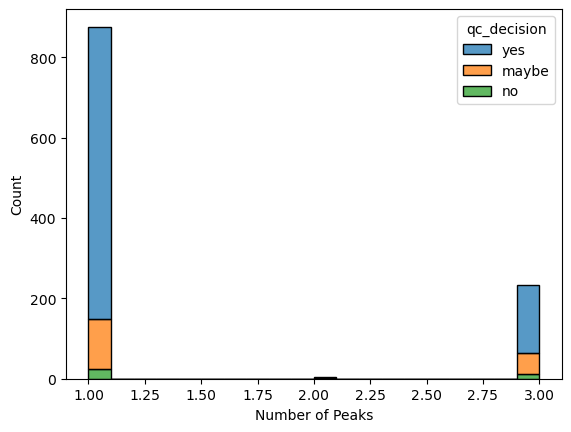

Number of peaks: 1
Total: 902
Yes: 727 (80.6%)
No: 23 (2.5%)
Maybe: 126 (14.0%)
--------------------------------------------------
Number of peaks: 2
Total: 6
Yes: 3 (50.0%)
No: 1 (16.7%)
Maybe: 0 (0.0%)
--------------------------------------------------
Number of peaks: 3
Total: 256
Yes: 168 (65.6%)
No: 11 (4.3%)
Maybe: 54 (21.1%)
--------------------------------------------------
Number of peaks: 4
Number of peaks: 5
Number of peaks: 6
Number of peaks: 7
Number of peaks: 8
Number of peaks: 9
Number of peaks: 10


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=peak_features, x='Number of Peaks', hue='qc_decision', multiple='stack', bins=20)
plt.show()

# Print the percentatge of each decision for each number of peaks

for i in range(1, 11):
    print(f'Number of peaks: {i}')
    subset = peak_features[peak_features['Number of Peaks'] == i]
    decision_counts = Counter(subset['qc_decision'])
    total = len(subset)
    if total != 0:
        yes = decision_counts['yes']
        no = decision_counts['no']
        maybe = decision_counts['maybe']
        print(f'Total: {total}')
        print(f'Yes: {yes} ({yes/total:.1%})')
        print(f'No: {no} ({no/total:.1%})')
        print(f'Maybe: {maybe} ({maybe/total:.1%})')
        print('-'*50)

In [ ]:
# Create a simple RF model to predict the QC decision based on the data

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

data = peak_features.copy()
# Drop any nan rows
data = data.dropna()

# Define the features and target variable
X = data.drop(columns=['Subject', 'qc_decision'])
y = data['qc_decision']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Predict the target variable for the testing data
y_pred = rf.predict(X_test)

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

# Print the feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print(feature_importances)



[[  2   0  22]
 [  2   0   7]
 [  5   0 185]]
Shapiro-Wilk Test Statistic               0.053287
Minimum                                   0.042783
Minimum Envelope 1                        0.041828
Median Envelope 1                         0.040455
Shapiro-Wilk Test Envelope 1 Statistic    0.039112
Median                                    0.038649
Minimum Envelope 2                        0.036068
Standard Deviation Envelope 2             0.034946
Main Peak Gradient                        0.034071
Standard Deviation Envelope 1             0.033748
Mean                                      0.033164
Shapiro-Wilk Test Envelope 2 Statistic    0.032907
Area under the curve (slice)              0.031533
Mean Envelope 1                           0.031284
Kurtosis Envelope 1                       0.030328
Skewness Envelope 1                       0.030017
Mean Envelope 2                           0.030010
Area under the curve                      0.029974
Main Peak Width                     